<a href="https://colab.research.google.com/github/dvignoles/sos/blob/master/SOS_GLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate maps for Science on a Sphere using Cartopy : GLM

This notebook outlines the process of creating maps formatted properly for the NOAA Science on a Sphere. The data used is from the [GOES-16 GLM](https://www.goes-r.gov/spacesegment/glm.html) flash extent density product.

## Daniel Vignoles August 2019
### NCEP Summer Internship

* dvignoles@gmail.com

## Python Environment

I used [Anaconda](https://www.anaconda.com/distribution/) to manage the python environment used in this project. Needed packages are listed in the imports below. As Anaconda in installed by default in your Home directory, no administator privileges are needed to install packages. If working on a restricted computer, this will save you *a lot* of time. If you end up needing to deploy a conda environment check out [conda-pack](https://conda.github.io/conda-pack/).

### Imports

In [0]:
#Interact with FTP servers
from ftplib import FTP

#Manipulate and extract Datetime information
from datetime import datetime

#Match patterns in strings (filenames and directories)
import re

#Matrix manipulation
import numpy as np
import numpy.ma as ma

#Extract data from .nc files 
from netCDF4 import Dataset

#Plotting/Mapping
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Get Data from STAR FTP server
ftp://ftp.star.nesdis.noaa.gov/pub/corp/goes_glm/goes16/FD_GRID_224urad/

In [0]:
ftp = FTP("ftp.star.nesdis.noaa.gov")
ftp.login()
ftp.cwd("pub/corp/goes_glm/goes16/FD_GRID_224urad")

'250 CWD command successful'

In [0]:
data_files = ftp.nlst()
for f in data_files[0:5]:
    print(f)

GLM-00-00_20190731_165900_60_1src_224urad-dx_flash_extent.nc
GLM-00-00_20190731_165800_60_1src_224urad-dx_flash_extent.nc
GLM-00-00_20190731_170000_60_1src_224urad-dx_flash_extent.nc
GLM-00-00_20190731_170100_60_1src_224urad-dx_flash_extent.nc
GLM-00-00_20190731_170200_60_1src_224urad-dx_flash_extent.nc


### Download the first file

In [0]:
chosen_file = data_files[0]
filedata = open(chosen_file, "wb")
print(ftp.retrbinary("RETR " + chosen_file, filedata.write))
filedata.close()

226 Transfer complete


### Extract datetime from filename

In [0]:
print(chosen_file)
print(chosen_file[10:25])

GLM-00-00_20190731_165900_60_1src_224urad-dx_flash_extent.nc
20190731_165900


In [0]:
pattern = re.compile(r'\d{8}_\d{6}')
date_str = pattern.search(chosen_file).group()

FORMAT = '%Y%m%d_%H%M%S'
date_dt = datetime.strptime(date_str, FORMAT)
print(date_dt)

2019-07-31 16:59:00


### Read our netcdf file into memory

In [0]:
data = Dataset(chosen_file,'r')

In [0]:
data.variables.keys()

odict_keys(['goes_imager_projection', 'x', 'y', 'time', 'flash_extent_density'])

### Extract projection information

In [0]:
data.variables['goes_imager_projection']

<class 'netCDF4._netCDF4.Variable'>
int32 goes_imager_projection()
    long_name: GOES-R ABI fixed grid projection
    grid_mapping_name: geostationary
    perspective_point_height: 35786023.0
    semi_major_axis: 6378137.0
    semi_minor_axis: 6356752.31414
    inverse_flattening: 298.2572221
    latitude_of_projection_origin: 0.0
    longitude_of_projection_origin: -75.0
    sweep_angle_axis: x
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used

In [0]:
# extract projection info
goes_proj = data.variables['goes_imager_projection']
semi_major = goes_proj.semi_major_axis
semi_minor = goes_proj.semi_minor_axis
central_lon = goes_proj.longitude_of_projection_origin
central_lat = goes_proj.latitude_of_projection_origin
sat_height = goes_proj.perspective_point_height
sweep_axis = goes_proj.sweep_angle_axis
inverse_flattening = goes_proj.inverse_flattening

In [0]:
# define globe / crs
globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor,
                   inverse_flattening=inverse_flattening)

goes_crs = ccrs.Geostationary(central_longitude=central_lon, satellite_height=sat_height,
                              sweep_axis=sweep_axis, globe=globe)

### Extract coordinates & data

In [0]:
x = data.variables['x'][:] * sat_height
y = data.variables['y'][:] * sat_height
fed = data.variables['flash_extent_density'][0,:,:]

In [0]:
print(x.shape)
print(y.shape)
print(fed.shape)

(1355,)
(1355,)
(1355, 1355)


### Set up our canvas (Figure + Axes)

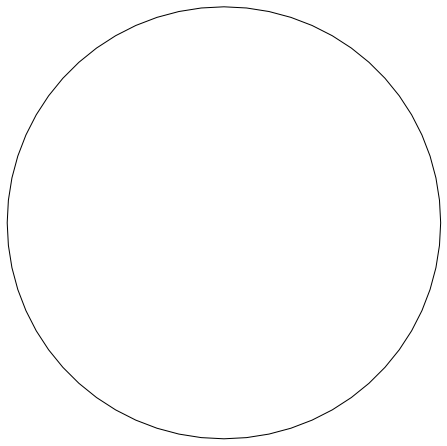

In [0]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0, 0, 1, 1], frameon=False, projection=goes_crs)

### Remove Border and Background

In [0]:
ax.outline_patch.set_visible(False)
ax.background_patch.set_visible(False)

### Add basemap

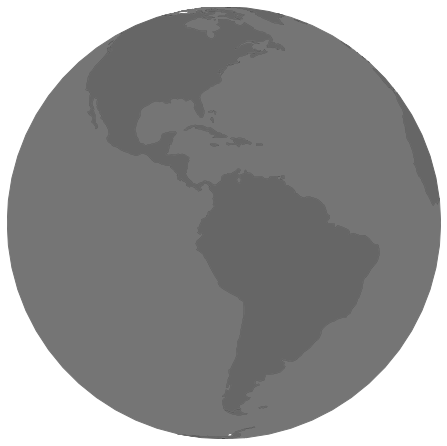

In [0]:
ax.add_feature(cfeature.LAND,facecolor='#666666')
ax.add_feature(cfeature.OCEAN,facecolor='#757575')
ax.coastlines(linewidth=0.1)
fig

### Let's define a convenience function resetting our map

In [0]:
def map_setup(crs,width=12,height=6):
    fig = plt.figure(figsize=(width,height))
    ax = fig.add_axes([0, 0, 1, 1], frameon=False, projection=crs)
    ax.outline_patch.set_visible(False)
    ax.background_patch.set_visible(False)
    ax.add_feature(cfeature.LAND,facecolor='#666666')
    ax.add_feature(cfeature.OCEAN,facecolor='#757575')
    ax.coastlines(linewidth=0.1)
    return fig,ax

### Also, let's create a custom colormap

In [0]:
def lin_cmap(colors,bounds):

    cmap = LinearSegmentedColormap.from_list('mycolormap', colors, N=int(len(colors)))

    norm = BoundaryNorm(bounds, cmap.N)
    
    return cmap,norm

In [0]:
# Yellow -> Red colormap
segments = list(range(1, 11))
lightning_cmap, norm = lin_cmap(['#F9FA00', '#F9DE00', '#FAC200', '#FAA600', '#FB8A00',
                                 '#FB6F00', '#FC5300', '#FC3700', '#FD1B00', '#FE0000'], bounds=segments)

### Add data

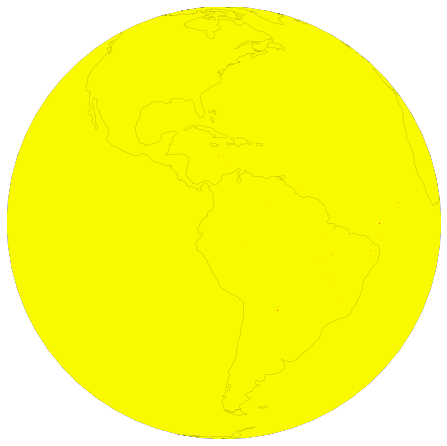

In [0]:
mappable = ax.pcolormesh(x, y, fed, cmap=lightning_cmap, norm=norm,transform=goes_crs)
fig

### That doesn't look quite right....It seems values of 0 are not masked with the dataset.
Let's mask values less than 1

In [0]:
fed = ma.masked_where(fed < 1.0, fed)

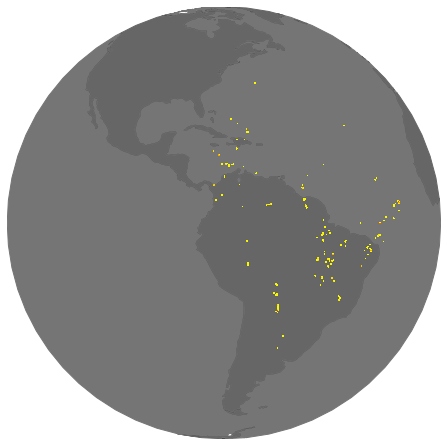

In [0]:
fig,ax = map_setup(goes_crs)

mappable = ax.pcolormesh(x, y, fed, cmap=lightning_cmap, norm=norm,transform=goes_crs)

### Better. But something is still off. No lighting above the CONUS doesn't seem likely. The orientation of our matrix may be off.

In [0]:
# Fix matrix orientation
fed = np.flip(np.rot90(fed), axis=0)

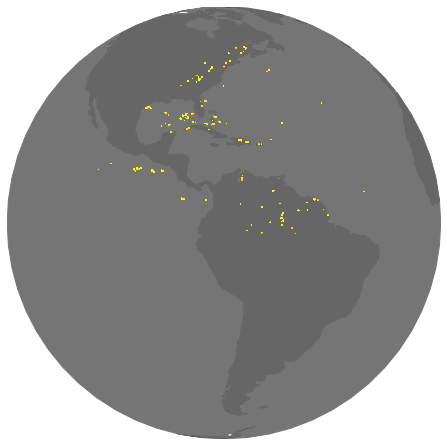

In [0]:
fig,ax = map_setup(goes_crs)

mappable = ax.pcolormesh(x, y, fed, cmap=lightning_cmap, norm=norm,transform=goes_crs)

### That's more like it! Let's try this with an SOS friendly projection

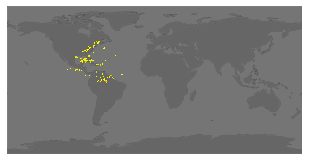

In [0]:
fig,ax = map_setup(ccrs.PlateCarree(),width=4.096,height=2.048)
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
mappable = ax.pcolormesh(x, y, fed, cmap=lightning_cmap,norm=norm, transform=goes_crs)

### Save our Map
Multiply Width and Height by dpi to determine resolution.

4.096 * 1000 = 4096

2.048 * 1000 = 2048

Resolution: 4096x2048

In [0]:
fig.set_size_inches(4.096,2.048)
filename = 'fed_' + date_dt.strftime('%Y-%m-%d_%H-%M-%S') + '.png'
fig.savefig(filename, dpi=1000)
print(filename)

fed_2019-07-31_16-59-00.png


### Save colorbar

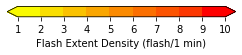

In [0]:
fig,ax = plt.subplots(figsize=(4.096,2.048))

cbar = plt.colorbar(mappable, orientation='horizontal',
                    extend='both', ticks=segments)

cbar.set_label('Flash Extent Density (flash/1 min)')

ax.remove()
plt.savefig('fed_colorbar.png', dpi=250, bbox_inches='tight',
            pad_inches=0, transparent=True)